# Convert 9 Frames into 1 Image
This notebook creates training images for a sequence classifier. Give the algorithm any portion of `train_labels.csv` and it will convert 9 consective frames into a single image and save to disk for fast retrievial later during training.

Using helmet ground truth bboxs, this notebook takes 4 previous frames and 4 following frames with `step=4`. It takes `128x128` crops around bbox from all frames and tiles the 9 crops into a single `384x384` image.

You can modify the `step` and the `crop` size. It will always make 9 crops. Of course your model can choose to use less. We could use more but then it makes inference longer so 9 or less is probably best.

In [1]:
STEP = 4
CROP = 128

In [2]:
import pandas as pd, numpy as np
import cv2, os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/raid/Kaggle/NFL/train_labels.csv')
print( df.shape )
df.head()

(983885, 14)


,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN


In [4]:
impacts = df.loc[(df.impact==1)&(df.confidence>1)&(df.visibility>0)]
print( impacts.shape )
impacts.head()

(1888, 14)


,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
746,57583,82,Endzone,57583_000082_Endzone.mp4,38,H99,582,21,311,27,1.0,Helmet,2.0,2.0
754,57583,82,Endzone,57583_000082_Endzone.mp4,38,V68,562,18,313,15,1.0,Helmet,2.0,2.0
967,57583,82,Endzone,57583_000082_Endzone.mp4,49,H97,425,15,311,20,1.0,Helmet,3.0,3.0
969,57583,82,Endzone,57583_000082_Endzone.mp4,49,V72,434,18,316,15,1.0,Helmet,3.0,3.0
1007,57583,82,Endzone,57583_000082_Endzone.mp4,51,V73,614,19,317,14,1.0,Shoulder,3.0,3.0


In [5]:
idx = impacts.groupby(['gameKey','playID','frame','view']).size().index.values
idx

array([(57583, 82, 38, 'Endzone'), (57583, 82, 38, 'Sideline'),
       (57583, 82, 49, 'Endzone'), ..., (58107, 4362, 400, 'Endzone'),
       (58107, 4362, 438, 'Endzone'), (58107, 4362, 441, 'Sideline')],
      dtype=object)

In [6]:
%%time

INPUT = '/raid/Kaggle/NFL/frames/'
OUTPUT = '/raid/Kaggle/NFL/crops_v0/'
black = np.zeros((720,1280,3),dtype='uint8')

print('Processing',len(idx),'frames...')
for i,k in enumerate(idx):
    if i%25==0: print(i,', ',end='')
    tmp = impacts.loc[(impacts.gameKey==k[0])&(impacts.playID==k[1])&(impacts.frame==k[2])&(impacts['view']==k[3])]
    imgs = []
    for j in range(k[2]-4*STEP,k[2]+5*STEP,STEP):
        name = '%i_%.6i_%s_%i.png'%(k[0],k[1],k[3],j)
        if not os.path.isfile(INPUT+name):
            print('(Missing %i %i %i %s) '%(k[0],k[1],k[2],k[3]),end='')
            img = black
        else:
            img = cv2.imread(INPUT+name)
        imgs.append(img)
    for index,row in tmp.iterrows():
        final = np.zeros((CROP*3,CROP*3,3),dtype='uint8')
        x = row.left + row.width//2
        y = row.top + row.height//2
        for j in range(9):
            rw = j//3; cl = j%3
            STP = CROP//2
            x1 = cl*CROP
            x2 = (cl+1)*CROP
            y1 = rw*CROP
            y2 = (rw+1)*CROP
            if x<STP: x1 = x1 + (STP-x)
            if x>1280-STP: x2 = x2 - (x-1280+STP)
            if y<STP: y1 = y1 + (STP-y)
            if y>720-STP: y2 = y2 - (y-720+STP)
            x3 = np.clip(x-STP,0,None)
            y3 = np.clip(y-STP,0,None)
            final[y1:y2,x1:x2] = imgs[j][y3:y+STP,x3:x+STP,:]
        name = '%i_%.6i_%s_%i_%.6i.png'%(k[0],k[1],k[3],k[2],index)
        cv2.imwrite(OUTPUT+name,final)

Processing 1201 frames...
0 , 25 , 50 , 75 , 100 , 125 , 150 , 175 , 200 , 225 , 250 , 275 , 300 , 325 , 350 , 375 , 400 , 425 , 450 , 475 , 500 , 525 , 550 , 575 , 600 , 625 , 650 , 675 , 700 , 725 , 750 , 775 , 800 , 825 , 850 , 875 , 900 , 925 , 950 , 975 , 1000 , 1025 , 1050 , 1075 , 1100 , 1125 , 1150 , 1175 , 1200 , CPU times: user 4min 28s, sys: 13.5 s, total: 4min 41s
Wall time: 4min 41s


In [7]:
FILES = os.listdir(OUTPUT)
print('Sequences made =', len(FILES) )
FILES[:10]

Sequences made = 1888


['57993_000475_Endzone_124_696547.png',
 '57679_003316_Endzone_112_212820.png',
 '58107_004362_Sideline_329_981284.png',
 '57680_002206_Sideline_294_235513.png',
 '57584_000336_Sideline_81_031818.png',
 '57700_001264_Endzone_38_300935.png',
 '57910_001164_Sideline_241_574911.png',
 '58107_004362_Sideline_62_975810.png',
 '57992_000301_Sideline_90_670430.png',
 '57775_000933_Sideline_80_324094.png']

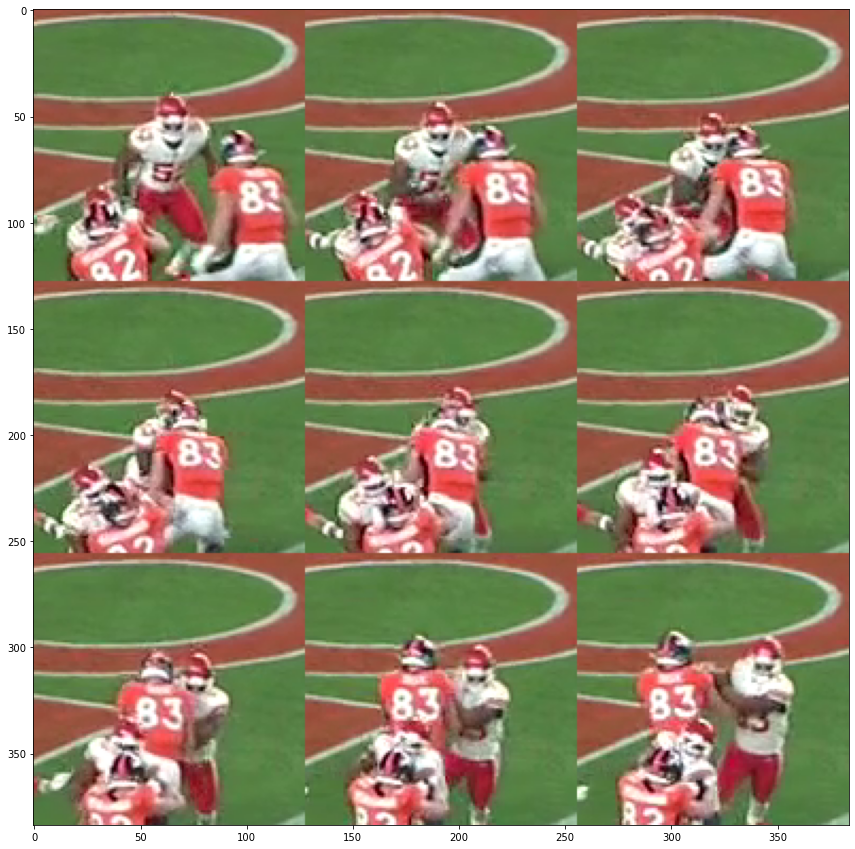

In [8]:
img = cv2.imread(OUTPUT+FILES[8])
plt.figure(figsize=(15,15))
plt.imshow(img[:,:,::-1])
plt.show()